# Visualizing the data structure



In [2]:
import numpy as np
from matplotlib import pyplot as plt
import arviz as az
from pymob import Config
from pymob.sim.config import Param
from pymob.sim.plot import SimulationPlot

In [3]:
from hierarchical_molecular_tktd.sim import (
    NomixHierarchicalSimulation, 
    conditional_survival_error_model, 
    conditional_survival_error_model_old,
    plot_y0
)

In [ ]:
# load case study
config = Config("../scenarios/hierarchical_cext_nested/settings.cfg")
config.case_study.package = "../.."
config.case_study.data_path = "../../tktd_rna_pulse/data"
sim = NomixHierarchicalSimulation(config)
sim.setup()
sim.dispatch_constructor()

/home/flo-schu/miniconda3/envs/damage-proxy/lib/python3.11/site-packages/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


Working directory: '/home/flo-schu/projects/hierarchical_tktd'.
MinMaxScaler(variable=cint, min=1e-08, max=6582.763087754983)
MinMaxScaler(variable=nrf2, min=0.6215531717356583, max=3.806557074337876)
MinMaxScaler(variable=survival, min=0.0, max=18.0)
Results directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/results/hierarchical_cext_nested'.
Scenario directory exists at '/home/flo-schu/projects/hierarchical_tktd/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext_nested'.


## Implementing the nested hierarchical error structure for $C_{ext,0}$ ($y_0$)

The stock solutions for each experiment are prepared freshly before the experiment. Exposure solutions are created as direct dilutions from the stock. This means, there is **no** error propagation, through the different dilution steps in different treatments. But, each stock solution can be subject to a preparation error and treatment solutions can also be subject to errors.

Let's unpack the experimental error structure

In [5]:
# create an index and add it to the simulation
experiment_index = sim.create_index("experiment_id")
sim.indices.update(experiment_index)

At first we take a look at the already present $y_0$ structure of the previous scenario (notebook).

In [6]:
sim.config.model_parameters.cext_y0 = Param(dims=("id",), prior=f"lognorm(scale=cext_y0,s=1)", free=True)
print(f"'cext_y0' parameter shape: {sim.parameter_shapes['cext_y0']}")

'cext_y0' parameter shape: (314,)


In [7]:
sim.use_numpyro_backend(error_model=conditional_survival_error_model, only_prior=False)

Jax 64 bit mode: False
Absolute tolerance: 1e-06


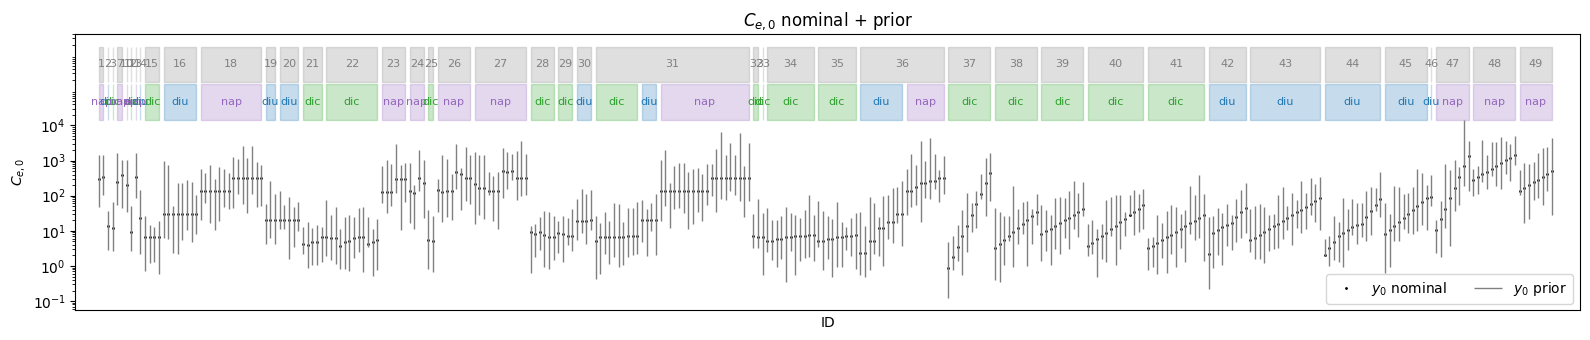

In [8]:
idata = sim.inferer.prior_predictions(n=10)
plot_y0(sim=sim, idata=idata, parameter="cext", idata_group="prior", levels=["experiment_id", "substance",], colors={"substance": ["tab:green", "tab:blue", "tab:purple"]})


We see that the prior probability is evenly distributed around the nominal $y_0$ values on the log scale. In addition, we notice that also almost each experiment was conducted on a separate day, leading to batch effects in the experimental conduction, and especially the zebrafish embroys.

Next we look at the prior distributions when we use an error model mapped by experiment

In [105]:
# create a parameter with the new dimension and add it at first position to the model_parameters
sigma_experiment = Param(dims=("experiment_id",), prior="lognorm(scale=1, s=1)", hyper=True, free=True)
cext_y0 = Param(dims=("id",), prior=f"deterministic(value=cext_y0*sigma_experiment[experiment_id_index])", free=True)

sim.config.model_parameters.cext_y0 = cext_y0
sim.config.model_parameters.sigma_experiment = sigma_experiment
sim.config.model_parameters.reorder(["sigma_experiment", "cext_y0"])
print(f"'sigma_experiment' parameter shape: {sim.parameter_shapes['sigma_experiment']}")
print(f"'cext_y0' parameter shape: {sim.parameter_shapes['cext_y0']}")


'sigma_experiment' parameter shape: (42,)
'cext_y0' parameter shape: (314,)


/home/flo-schu/projects/pymob/pymob/sim/parameters.py:126: UserWarning: The distribution 'deterministic' is not part of the scipy distributions implemented in pymob. This can lead to inconsistent behavior. It is recommended to use the scipy distribution protocol where possible. https://docs.scipy.org/doc/scipy/reference/stats.html It may also be possible that your distribution has not yet been introduced into the pymob package 
  warnings.warn(


In [106]:
sim.use_numpyro_backend(error_model=conditional_survival_error_model, only_prior=False)

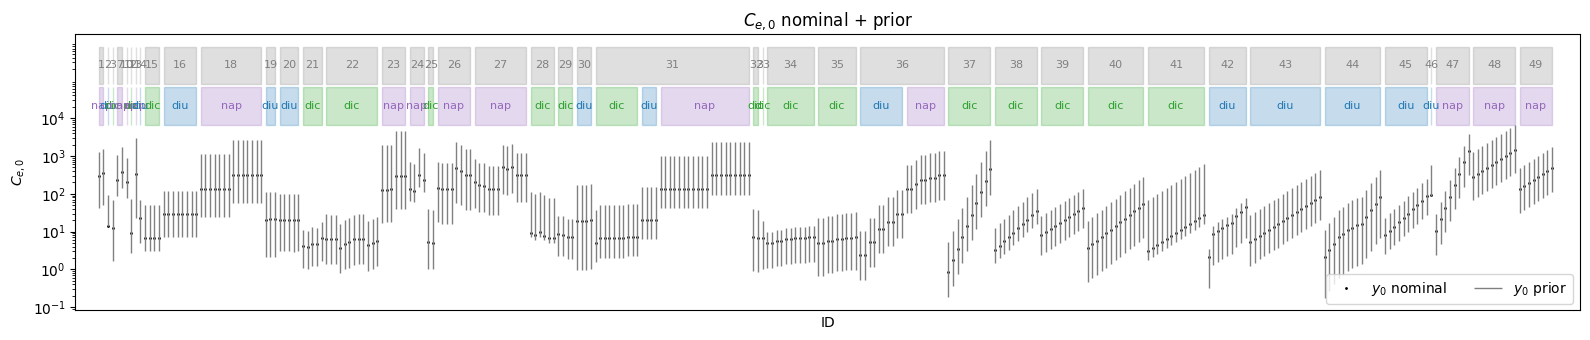

In [107]:
idata = sim.inferer.prior_predictions(n=10)
plot_y0(sim=sim, idata=idata, parameter="cext", idata_group="prior", levels=["experiment_id", "substance",], colors={"substance": ["tab:green", "tab:blue", "tab:purple"]})

As opposed to the previous prior specification, we now set the starting value $y_0$ deterministically and only vary the error of the experiment (which is multiplicative). Note that any **non-centered appearing priors are only due to sampling only 10 prior draws**. This means this prior specification is a bit more restrictive, because it assumes that error on the starting values depend on the experiment, and not on each individual treatment.

In [ ]:
substance_index = sim.create_index("substance")

substance_index["substance"].values[experiment_index["experiment_id"] == 27]


In [116]:
sim.config.inference_numpyro.kernel = "svi"
sim.config.inference.n_predictions = 100
sim.config.inference_numpyro.init_strategy = "init_to_uniform"
sim.config.inference_numpyro.svi_iterations = 1000
sim.config.inference_numpyro.svi_learning_rate = 0.01
sim.config.simulation.seed=4
sim.dispatch_constructor()

if False:
    sim.inferer.run()
    sim.inferer.store_results(output=f"{sim.output_path}/numpyro_svi_posterior.nc")
    idata = sim.inferer.idata
else:
    idata = sim.inferer.load_results(file="numpyro_svi_posterior.nc")

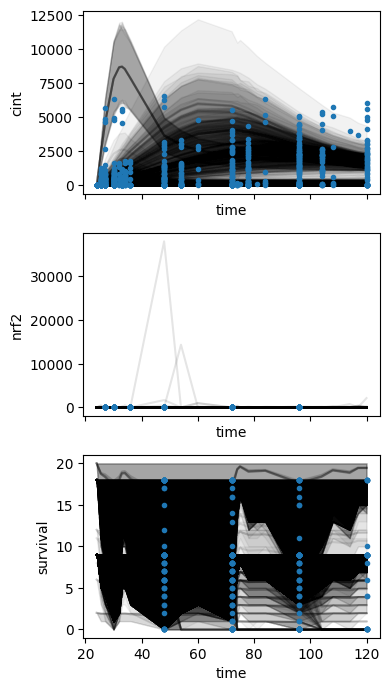

In [113]:
simplot = SimulationPlot(
    observations=sim.observations,
    idata=sim.inferer.idata,
    coordinates=sim.dimension_coords,
    config=sim.config,
    idata_groups=["posterior_predictive"],
)   
simplot.plot_data_variables()

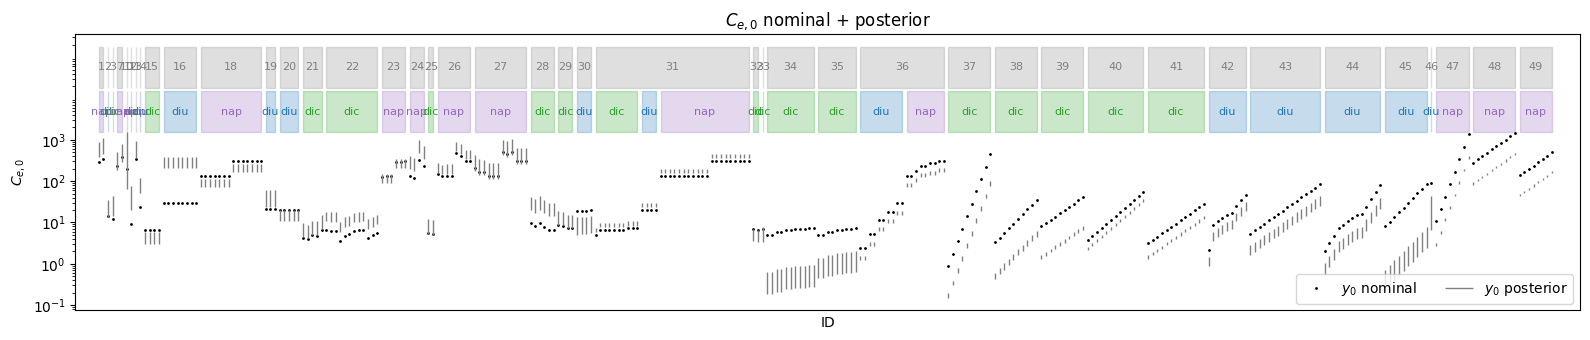

In [114]:
plot_y0(sim=sim, idata=sim.inferer.idata, parameter="cext", idata_group="posterior", levels=["experiment_id", "substance",], colors={"substance": ["tab:green", "tab:blue", "tab:purple"]})

There are interesting insights in this work. For some experiments, there seems to be a structural underestimation

The *true* experimental concentrations are assumed to be very far off the nominal concentrations for some experiments. Sometimes more than a magnitude. This seems to be not very realistic. Here we should take a look at the hierarchical approach. Ideally, we could learn the overall experimental error by defining a hyperprior for the deviation between nominal and the true concentration.

In [117]:
sim.seed=2
sim.config.inference.n_predictions = 1
sim.coordinates["time"] = np.linspace(24,120,200)
sim.dispatch_constructor()
sim._plot.pretty_posterior_plot_multisubstance(sim)
sim.reset_coordinate("time")

PRETTY PLOT: starting...
PRETTY PLOT: make predictions for Diuron in bin (1/5)
PRETTY PLOT: make predictions for Diuron in bin (2/5)
PRETTY PLOT: make predictions for Diuron in bin (3/5)
PRETTY PLOT: make predictions for Diuron in bin (4/5)
PRETTY PLOT: make predictions for Diuron in bin (5/5)
PRETTY PLOT: make predictions for Diclofenac in bin (1/4)
PRETTY PLOT: make predictions for Diclofenac in bin (2/4)
PRETTY PLOT: make predictions for Diclofenac in bin (3/4)
PRETTY PLOT: make predictions for Diclofenac in bin (4/4)
PRETTY PLOT: make predictions for Naproxen in bin (1/6)
PRETTY PLOT: make predictions for Naproxen in bin (2/6)
PRETTY PLOT: make predictions for Naproxen in bin (3/6)
PRETTY PLOT: make predictions for Naproxen in bin (4/6)
PRETTY PLOT: make predictions for Naproxen in bin (5/6)
PRETTY PLOT: make predictions for Naproxen in bin (6/6)


![combined_pps_figure_diclofenac.png](../results/hierarchical_cext_nested/combined_pps_figure_diclofenac.png)
![combined_pps_figure_diuron.png](../results/hierarchical_cext_nested/combined_pps_figure_diuron.png)
![combined_pps_figure_naproxen.png](../results/hierarchical_cext_nested/combined_pps_figure_naproxen.png)

We see that some data can be fitted much better, but some dynamics are unrealistic. This is fine, it's a work in progress; I argued already that the metabolization dynamics for some substances are not correct. Especially for diclofenac. Fits for Diuron nrf2 are superb. And survival fits look good in any case. The thing is that currently the model has a lot of freedom to push the starting concentration to arbitrary values, especially for survival values this is convenient, because there are no simulatenous experiments that forbid this. I will automatically get very good fits, because the model can tell its own story. One way could be to be more conservative on the prior for y0-sigma, but learning a collective y0 is more interesting.

In [119]:
sim.config.case_study.scenario = "hierarchical_cext_nested_sigma_hyperprior"
sim.config.create_directory("scenario", force=True)
sim.config.save(force=True)

Scenario directory created at '/home/flo-schu/projects/pymob/case_studies/hierarchical_molecular_tktd/scenarios/hierarchical_cext_nested_sigma_hyperprior'.
